In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



### Some facts about the data



In [2]:
train_df = pd.read_csv("../data/verkehrsunfaelle_train.csv").drop(['Unnamed: 0'],axis=1)
test_df = pd.read_csv("../data/verkehrsunfaelle_test.csv").drop(['Unnamed: 0'],axis=1)

print("train_df shape: " + str(train_df.shape))
print("test_df shape: " + str(test_df.shape))

train_df shape: (15221, 13)
test_df shape: (1000, 12)


<br>
<br>
~15k rows of training data seems to be a quite low number to train a NN with TensorFlow etc. However, XGBoost, LightGBM or other gradient boosting algorithms should be promising for this kind of dataset, so we'll only concentrate on this kind of models and try to beat naive benchmarks that we set.

~1k rows of test data is also a fair number that probably can be fairly good approximated by a train/test split of the training data without loosing much data for the training itself. Of course, assuming that the distribution of the training and test data is roughly the same.
<br>
<br>

In [3]:
train_df.head()

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
0,Bundesstrasse,23. Jan.,59,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,2,trocken,männlich,1330,LKW ab 7.5t,Gut
1,Autobahn,17-May-11,48,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,4,trocken,weiblich,1724,Auto,Gut
2,nicht klassifiziert,14. Feb.,56,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,1,1,nass / feucht,männlich,1345,Mottorrad (500cc),Gut
3,Bundesstrasse,31-Oct-12,66,Fahrer,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,3,2,nass / feucht,weiblich,1830,Auto,Regen
4,Bundesstrasse,3. Nov.,33,Fahrer,2,Dunkelheit: keine Strassenbeleuchtung,1,1,nass / feucht,männlich,15,Auto,Gut


In [4]:
test_df.head()

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
0,Bundesstrasse,8. Dez.,37,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,2,2,nass / feucht,weiblich,1100,Auto,Gut
1,Bundesstrasse,29-May-10,43,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,3,2,nass / feucht,männlich,1710,Auto,Gut
2,nicht klassifiziert,04-Mar-09,63,Passagier,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,weiblich,1500,Bus,Gut
3,nicht klassifiziert,11-May-09,13,Fussgänger,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,männlich,1745,Auto,Gut
4,Bundesstrasse,5. Apr.,29,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,weiblich,1900,Auto,Gut


<br>
A little more info:
<br>
<br>

In [117]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15221 entries, 0 to 15220
Data columns (total 13 columns):
Strassenklasse         15221 non-null object
Unfalldatum            15221 non-null object
Alter                  15221 non-null int64
Unfallklasse           15221 non-null object
Unfallschwere          15221 non-null int64
Lichtverhältnisse      15221 non-null object
Verletzte Personen     15221 non-null int64
Anzahl Fahrzeuge       15221 non-null int64
Bodenbeschaffenheit    15221 non-null object
Geschlecht             15221 non-null object
Zeit (24h)             15221 non-null int64
Fahrzeugtyp            15221 non-null object
Wetterlage             15221 non-null object
dtypes: int64(5), object(8)
memory usage: 1.5+ MB
None


<br>
We got only 13 columns none of which have missing values. That's great news

<br>
Let's plot the target variable ('Unfallschwere') according to their occurences
<br>

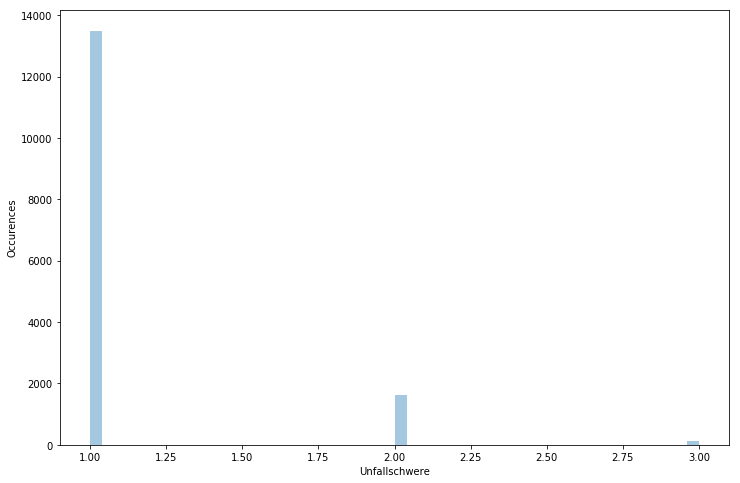

In [115]:
unfaelle = train_df["Unfallschwere"].values

plt.figure(figsize=(12, 8))
sns.distplot(unfaelle, kde=False)
plt.xlabel('Unfallschwere')
plt.ylabel('Occurences')
plt.show()

<br>
<br>
Seems we have a quite unbalanced dataset in terms of the distribution of the target variable. It might be quite hard to predict the class '3' cases with so little examples of this class. Thus we might have to do something against this imbalance while training.
<br>
<br>

### Exploration of Features

We have a fairly small amount of features in the dataset, therefore we can make a little effort here to look deeper into those one by one and see if we can find some useful insights.



#### Feature 'Strassenklasse':

In [14]:
train_df['Strassenklasse'].unique()

train_df.groupby('Strassenklasse')['Strassenklasse'].count()

Strassenklasse
Autobahn                 899
Bundesstrasse           5733
Kraftfahrzeugstrasse     343
Landesstrasse            902
nicht klassifiziert     7330
unbefestigte Strasse      14
Name: Strassenklasse, dtype: int64

In [123]:
pd.crosstab(train_df["Unfallschwere"], train_df["Strassenklasse"], normalize=True, margins=True)

Strassenklasse,Autobahn,Bundesstrasse,Kraftfahrzeugstrasse,Landesstrasse,nicht klassifiziert,unbefestigte Strasse,All
Unfallschwere,,,,,,,
1,0.054070,0.333618,0.020892,0.052559,0.424676,0.000788,0.886604
2,0.004533,0.039616,0.001314,0.006504,0.054201,0.000131,0.106301
3,0.000460,0.003416,0.000328,0.000197,0.002694,0.000000,0.007095
All,0.059063,0.376651,0.022535,0.059260,0.481572,0.000920,1.000000


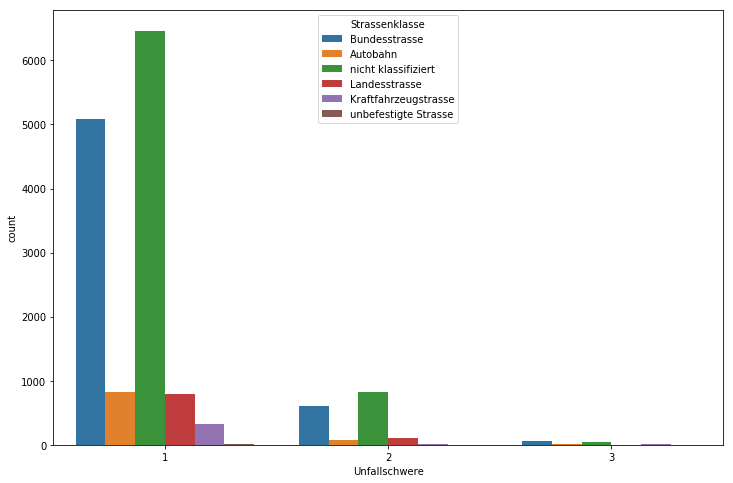

In [128]:
plt.figure(figsize=(12,8))

sns.countplot(x='Unfallschwere', hue='Strassenklasse', data=train_df)

So street types ('Strassenklasse') seem to be distributed equally across the classes of accident severity ('Unfallschwere'). Prior, we might have proposed the hypothesis that accident severity increases in numbers where people are allowed or tend to drive faster.

#### Feature 'Unfalldatum'

In [132]:
train_df["Unfalldatum"].unique()

array(['23. Jan.', '17-May-11', '14. Feb.', '31-Oct-12', '3. Nov.',
       '31-May-09', '24. Okt.', '25. Jul.', '7. Jan.', '10. Sep.',
       '21. Nov.', '26. Nov.', '10-Dec-09', '19-Dec-12', '09-Dec-11',
       '11. Okt.', '19. Jan.', '20-Oct-12', '15. Aug.', '15. Jun.',
       '24. Aug.', '14. Sep.', '07-Oct-11', '5. Jul.', '9. Sep.',
       '27. Sep.', '2. Feb.', '13. Feb.', '10. Apr.', '24. Feb.',
       '11-Dec-10', '28. Jun.', '31-May-12', '5. Nov.', '8. Aug.',
       '9. Jul.', '17-May-12', '9. Okt.', '01-Mar-11', '5. Jun.',
       '27. Apr.', '23. Aug.', '01-Oct-10', '13. Aug.', '27. Jul.',
       '18. Aug.', '23. Mai.', '4. Dez.', '31-Dec-12', '23. Sep.',
       '3. Jun.', '24-Dec-09', '20-May-09', '14. Mai.', '30-Dec-10',
       '14. Jun.', '2. Mai.', '17. Feb.', '24. Jun.', '22. Jul.',
       '31. Jul.', '28-Oct-09', '26. Okt.', '29. Jun.', '31. Okt.',
       '05-Oct-11', '10. Nov.', '21. Sep.', '7. Dez.', '11. Jan.',
       '8. Dez.', '06-Mar-12', '3. Aug.', '18. Jan.', '7.

In [130]:
test_df["Unfalldatum"].unique()

array(['8. Dez.', '29-May-10', '04-Mar-09', '11-May-09', '5. Apr.',
       '17. Jun.', '31. Dez.', '14. Sep.', '8. Feb.', '15. Nov.',
       '11. Feb.', '29-May-09', '2. Apr.', '12-Oct-12', '22. Apr.',
       '5. Jun.', '24. Feb.', '29-Oct-12', '08-Mar-11', '24. Mai.',
       '13. Jul.', '25. Aug.', '31-Mar-09', '31. Okt.', '6. Jun.',
       '23. Apr.', '12-Oct-09', '04-May-11', '30. Okt.', '3. Jul.',
       '21. Jun.', '8. Mai.', '15. Jun.', '20. Apr.', '19. Aug.',
       '22. Sep.', '30. Sep.', '9. Apr.', '24. Jul.', '26-May-09',
       '3. Aug.', '24. Aug.', '16. Jul.', '26. Sep.', '10-Mar-11',
       '1. Jun.', '16. Sep.', '15. Okt.', '27. Apr.', '20. Sep.',
       '21. Jan.', '11. Aug.', '20. Jul.', '21-Dec-12', '2. Jun.',
       '19. Jun.', '22. Nov.', '5. Nov.', '6. Feb.', '19. Mai.',
       '19-Oct-09', '19. Nov.', '16. Jun.', '8. Sep.', '9. Feb.',
       '8. Apr.', '18. Jul.', '1. Sep.', '13-Dec-09', '18-Mar-11',
       '11. Mai.', '25-Oct-09', '29. Sep.', '28. Sep.', '17. Jul

The Feature 'Unfalldatum' seems to be a tricky one to handle since we have a mixture of formatting styles of the dates. We have a mixture of separating the date representation, i.e. DD.MM.YYYY and DD-MM-YYYY which looks a mixture of german and american notation. However, it appears that, although the american notation with dashes ('-') is used, the order of day, month and year is uniformly documented in the german style (DD-MM-YY instead of MM-DD-YY).

Moreover, we have an inconistency in documentation of the year in which the accidents happened. However, looking by the dates which do have the year documented, it seems that the data could comprise the years 2009-2012 and applies for both the training and the test data. So in order to squeeze more information out of this feature, we assume that the underlying data was captured between the years 2009-2012 and that the rows were randomly split into training and test data, thus we have no time-series analysis. 